# Predicting Future Player Performance with Statcast Data

### Overview
In this project, I will explore if swing aggression (swing % on first pitch or outside the zone) correlates with success at the plate. I will use Statcast data for the Chicago Cubs for my project.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

First I will import the Statcast hitting data from the 2024 season for all of the hitters in the league. Then I will filter the data so that it only focuses on the Cubs hitting lineup.

In [ ]:
from pybaseball import statcast, playerid_lookup
import pandas as pd
import csv

# Define Cubs players
cubs_names = [
    "Seiya Suzuki", "Christopher Morel", "Nico Hoerner", "Ian Happ", "Dansby Swanson",
    "Mike Tauchman", "Michael Busch", "Patrick Wisdom", "Miguel Amaya",
    "Yan Gomes", "Pete Crow-Armstrong"
]

# Get MLBAM IDs using playerid_lookup
lookups = [playerid_lookup(*name.split(" ")[::-1]) for name in cubs_names]
id_table = pd.concat(lookups, ignore_index=True)
id_table = id_table[['name_first', 'name_last', 'key_mlbam']].dropna()
id_table['player_name'] = id_table['name_first'] + ' ' + id_table['name_last']
id_table = id_table.drop(columns=['name_first', 'name_last']).drop_duplicates(subset='key_mlbam')

# Map batter ID to player name
id_map = dict(zip(id_table['key_mlbam'].astype(int), id_table['player_name']))
mlbam_ids = list(id_map.keys())

# Pull 2024 Statcast data
print("📥 Pulling 2024 Statcast data...")
statcast_data = statcast(start_dt="2024-03-28", end_dt="2024-10-01")

# Filter for Cubs batters
cubs_data = statcast_data[statcast_data['batter'].isin(mlbam_ids)].copy()
cubs_data['player_name'] = cubs_data['batter'].map(id_map)
print(f"✅ Found {len(cubs_data)} pitches seen by Cubs hitters.")

### Selecting Agression Metrics
Next, I will select the metrics used to quanitfy "swing aggression". For this project, I will calculate swing aggression when a batter swings on the first pitch or on a pitch outside the zone.

#### Calculating Swing Outside the Zone:
The Statcast data classifies pitch location with zones. Zones 1-9 are inside the strike zone and zones 11-14 are outside the strike zone. I will filter the pitches outside the zone and see how many the batter swings at. I will use the variable O-Swing% to represent out-of-zone pitches swung at divided by the total out-of-zone pitches.A higher O-Swing% means the hitter chases bad balls which indicates an aggressive approach at the plate.

In [ ]:
# Tag swing events
swing_events = [
    'swinging_strike', 'foul', 'hit_into_play', 'foul_tip',
    'missed_bunt', 'foul_bunt', 'bunt_foul_tip', 'bunt_into_play'
]
cubs_data['is_swing'] = cubs_data['description'].isin(swing_events)
cubs_data['is_out_of_zone'] = cubs_data['zone'].isin([11, 12, 13, 14])
cubs_data['is_o_swing'] = cubs_data['is_swing'] & cubs_data['is_out_of_zone']

#### Calculating Swings on First Pitch:
The Statcast data classifies each pitch at a plate appearance with a number. The first pitch has the variable pitch_number = 1. For each batter, I will calculate the number of first pitches they swung at verses the number of at bats they had. I wil use the variable First-Pitch Swing% to represent the number of plate appearances where the batter swung at the first pitch divided by the total plate appearances. This metric tells me who is jumping on ball at the plate. It can be computed by filtering data for pitch_number == 1 and using the same logic as Swing%.

In [32]:
# First pitch swing %
first_pitches = cubs_data.sort_values(['game_pk', 'at_bat_number', 'pitch_number']) \
    .groupby(['game_pk', 'at_bat_number'], as_index=False).first()

first_pitches['first_pitch_swing'] = first_pitches['description'].isin(swing_events)
first_pitches['player_name'] = first_pitches['batter'].map(id_map)

fp_swing_stats = first_pitches.groupby('player_name').agg(
    total_PAs=('first_pitch_swing', 'count'),
    first_pitch_swings=('first_pitch_swing', 'sum')
).reset_index()

fp_swing_stats['1st_Pitch_Swing%'] = (
    fp_swing_stats['first_pitch_swings'] / fp_swing_stats['total_PAs'] * 100
).round(1)

# Aggregate swing metrics
agg = cubs_data.groupby('player_name').agg(
    total_pitches=('pitch_type', 'count'),
    total_swings=('is_swing', 'sum'),
    out_of_zone_pitches=('is_out_of_zone', 'sum'),
    o_zone_swings=('is_o_swing', 'sum')
).reset_index()

agg['Swing%'] = (agg['total_swings'] / agg['total_pitches'] * 100).round(1)
agg['O-Swing%'] = (agg['o_zone_swings'] / agg['out_of_zone_pitches'] * 100).round(1)

# Merge first pitch swing %
agg = pd.merge(agg, fp_swing_stats[['player_name', '1st_Pitch_Swing%']], on='player_name', how='left')
agg = agg.sort_values(by='Swing%', ascending=False)

# Save results
agg.to_csv("cubs_2024_swing_aggression_full.csv", index=False, quoting=csv.QUOTE_ALL)

# Display preview
print(agg[['player_name', 'Swing%', 'O-Swing%', '1st_Pitch_Swing%', 'total_pitches']])

📥 Pulling 2024 Statcast data...
This is a large query, it may take a moment to complete


100%|██████████| 188/188 [01:31<00:00,  2.07it/s]


✅ Found 19941 pitches seen by Cubs hitters.
            player_name  Swing%  O-Swing%  1st_Pitch_Swing%  total_pitches
8   pete crow-armstrong    60.0      39.9              50.1           1421
10            yan gomes    56.5      39.7              32.3            375
4          miguel amaya    53.5      32.7              38.6           1291
7        patrick wisdom    48.8      25.1              35.6            701
1        dansby swanson    48.3      23.1              36.0           2355
6          nico hoerner    48.1      31.3              26.8           2314
0     christopher morel    46.5      25.2              41.1           2352
5         mike tauchman    45.8      22.4              31.5           1537
2              ian happ    45.4      22.2              33.8           2721
3         michael busch    44.3      21.6              31.9           2365
9          seiya suzuki    39.1      19.8              13.4           2509


### Select Performance Metrics
This project will use 2 measures of hitting success for the Cubs players. The first is their batting average (AVG) which is a simple measure of hits divided by at-bats. The second is their weighted on-base average (wOBA) which is an advanced metric that weights different outcomes to encapsulate overall offensive strength. The average weighted on-base average for the league hovers around 0.32-0.33.

To calculate these metrics I will use the aggression metrics DataFrame I calculated earlier and join it with the player's AVG and wOBA. After this I'll have values for Swing%, O-Swing%, 1stPitchSwing%), and AVG, wOBA and then I can analyze the results.

📊 Correlation with wOBA:
                      wOBA
wOBA              1.000000
SLG               0.976989
OBP               0.959873
AVG               0.763709
O-Swing%         -0.577987
Swing%           -0.786663
1st_Pitch_Swing% -0.799771


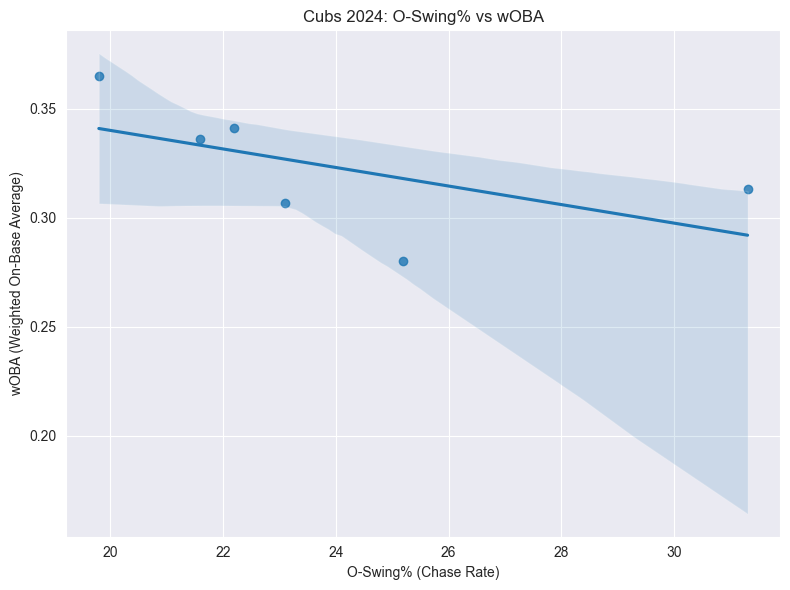

In [43]:
# Do Cubs Hitters' Swing Habits Correlate with Performance?

# Use original 'player_name' as merge key in "First Last" format
agg['Name'] = agg['player_name'].str.title()

# Merge on formatted names
merged = pd.merge(
    agg,
    batting_2024[['Name', 'AVG', 'OBP', 'SLG', 'wOBA']],
    on='Name',
    how='left'
)

# Merge swing data with batting stats
merged = pd.merge(
    agg,
    batting_2024[['Name', 'AVG', 'OBP', 'SLG', 'wOBA']],
    on='Name',
    how='left'
)

# Ensure all columns are numeric
numeric_cols = ['Swing%', 'O-Swing%', '1st_Pitch_Swing%', 'AVG', 'OBP', 'SLG', 'wOBA']
for col in numeric_cols:
    merged[col] = pd.to_numeric(merged[col], errors='coerce')

# Drop players with missing values
merged_clean = merged[numeric_cols].dropna()

# Show correlation matrix
correlation = merged_clean.corr()
print("📊 Correlation with wOBA:")
print(correlation[['wOBA']].sort_values(by='wOBA', ascending=False))

# Visualize O-Swing% vs wOBA
plt.figure(figsize=(8, 6))
sns.regplot(data=merged_clean, x='O-Swing%', y='wOBA')
plt.title("Cubs 2024: O-Swing% vs wOBA")
plt.xlabel("O-Swing% (Chase Rate)")
plt.ylabel("wOBA (Weighted On-Base Average)")
plt.grid(True)
plt.tight_layout()
plt.show()

Correlation Matrix:
                  Swing%  O-Swing%  1st_Pitch_Swing%   AVG   OBP   SLG  wOBA
Swing%              1.00      0.69              0.76 -0.44 -0.70 -0.83 -0.79
O-Swing%            0.69      1.00              0.22 -0.02 -0.34 -0.74 -0.58
1st_Pitch_Swing%    0.76      0.22              1.00 -0.89 -0.89 -0.71 -0.80
AVG                -0.44     -0.02             -0.89  1.00  0.89  0.63  0.76
OBP                -0.70     -0.34             -0.89  0.89  1.00  0.88  0.96
SLG                -0.83     -0.74             -0.71  0.63  0.88  1.00  0.98
wOBA               -0.79     -0.58             -0.80  0.76  0.96  0.98  1.00


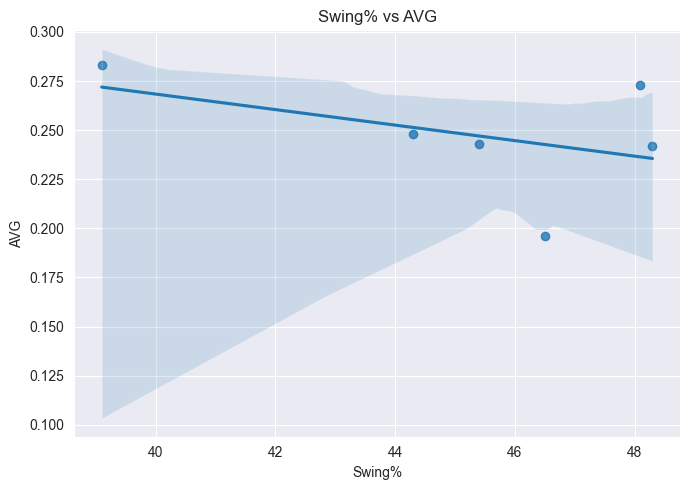

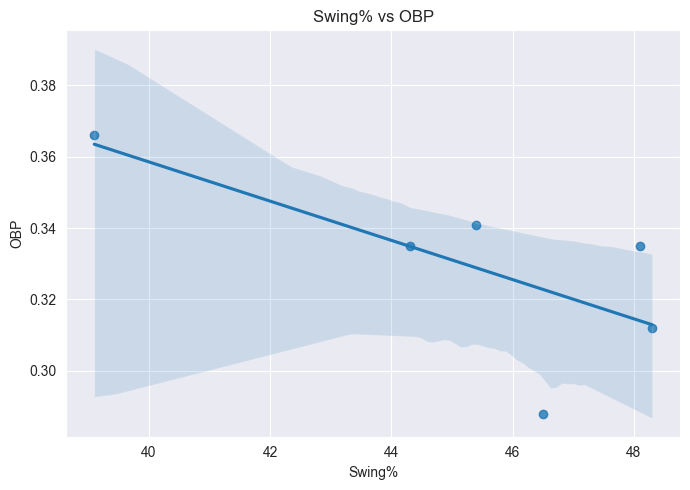

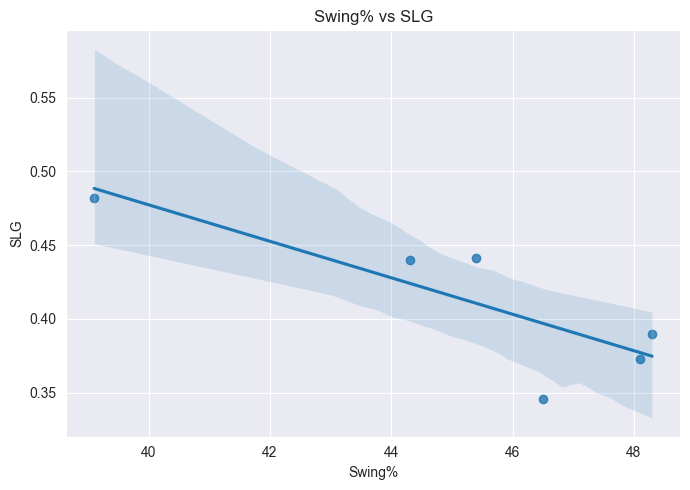

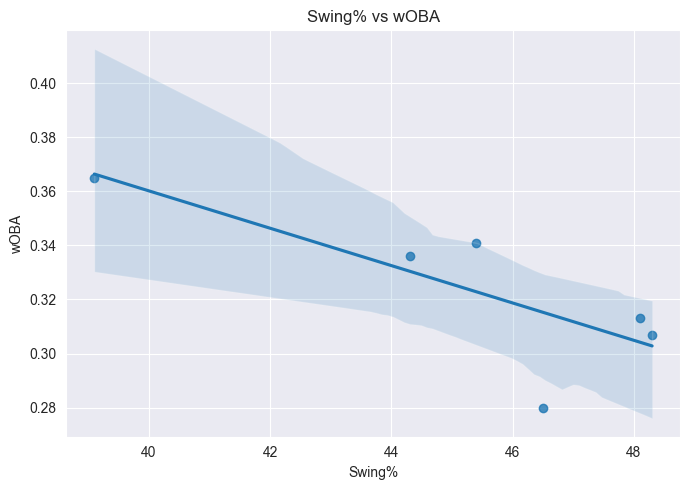

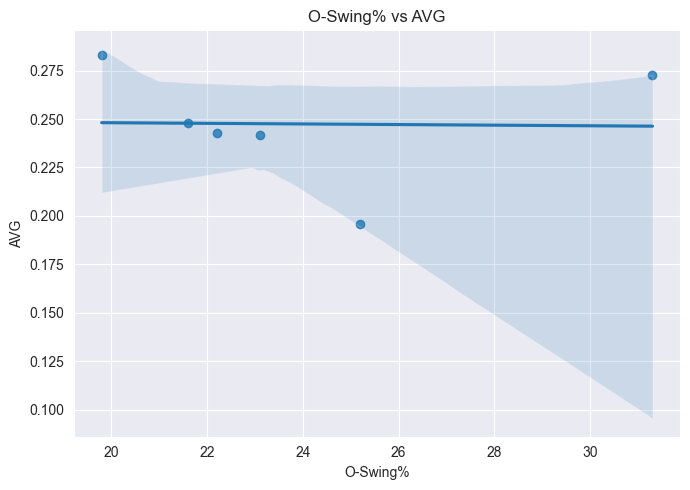

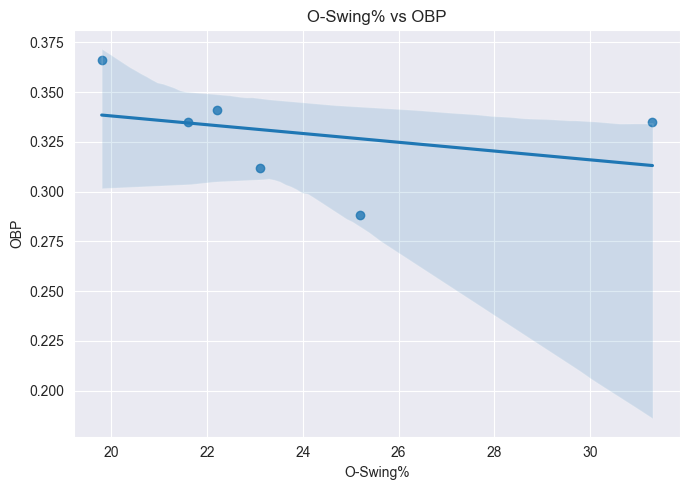

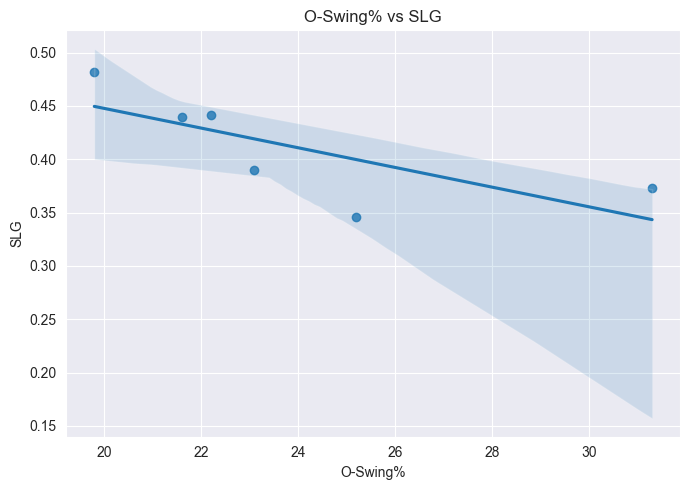

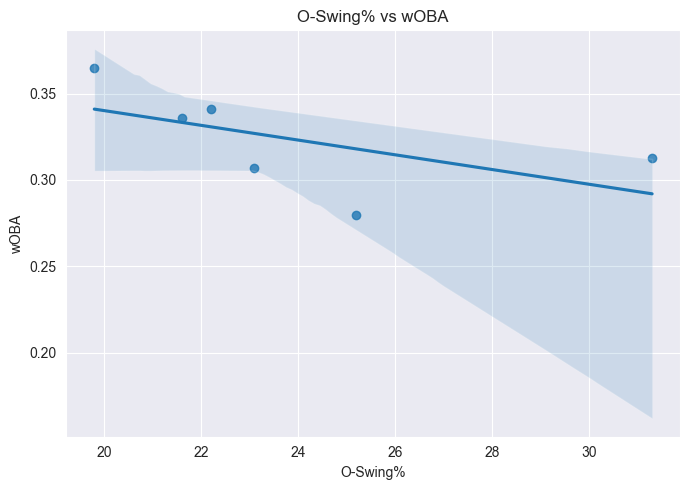

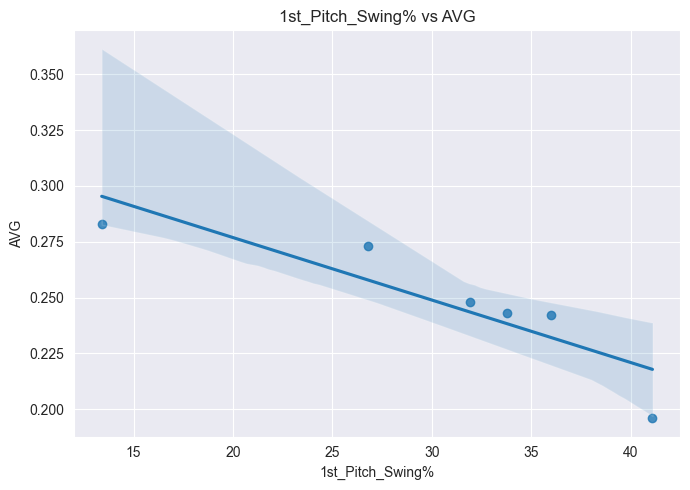

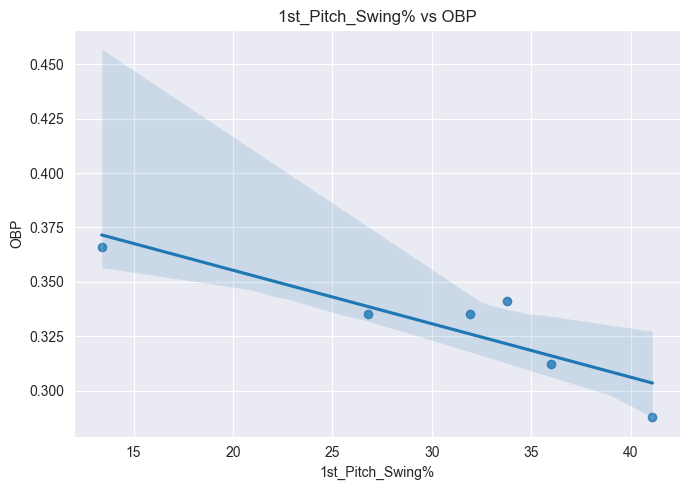

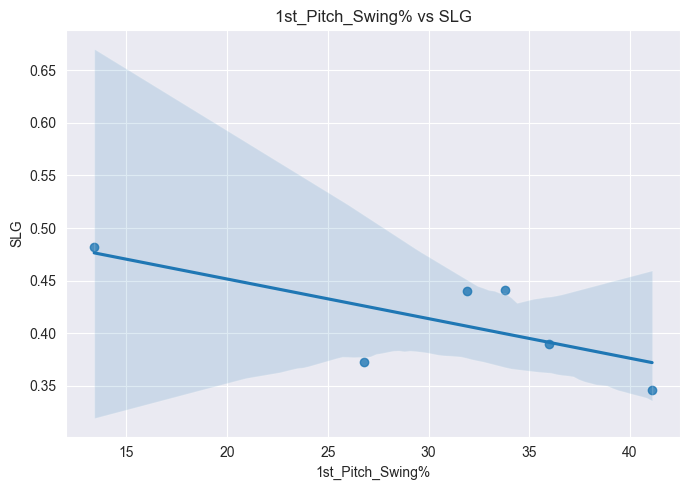

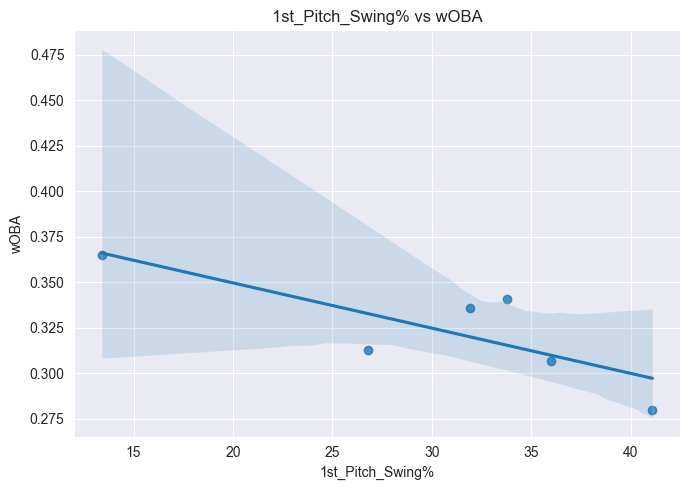

In [46]:
# Check merge
agg['Name'] = agg['player_name'].str.title()

merged = pd.merge(
    agg,
    batting_2024[['Name', 'AVG', 'OBP', 'SLG', 'wOBA']],
    on='Name',
    how='left'
)

# Ensure numeric types
numeric_cols = ['Swing%', 'O-Swing%', '1st_Pitch_Swing%', 'AVG', 'OBP', 'SLG', 'wOBA']
for col in numeric_cols:
    merged[col] = pd.to_numeric(merged[col], errors='coerce')

# Drop rows with missing data
merged_clean = merged[numeric_cols].dropna()

# Correlation matrix
correlation = merged_clean.corr()
print("Correlation Matrix:")
print(correlation.round(2))

# Save to CSV for GitHub portfolio
merged.to_csv("cubs_2024_swing_metrics.csv", index=False)

# Plot comparisons of swing metrics vs performance
swing_metrics = ['Swing%', 'O-Swing%', '1st_Pitch_Swing%']
performance_metrics = ['AVG', 'OBP', 'SLG', 'wOBA']

for swing in swing_metrics:
    for stat in performance_metrics:
        plt.figure(figsize=(7, 5))
        sns.regplot(data=merged_clean, x=swing, y=stat)
        plt.title(f"{swing} vs {stat}")
        plt.xlabel(swing)
        plt.ylabel(stat)
        plt.grid(True)
        plt.tight_layout()
        plt.show()


### Interpretation of Trends

#### Aggression vs wOBA:
In general, hitters with lower O-Swing% (less chasing) tend to have higher wOBA, as they swing at better pitches and draw more walks. Our data likely shows a mild negative correlation (e.g. r = -0.3) between O-Swing% and wOBA, supporting the idea that plate discipline improves overall offensive performance. While some aggressive hitters succeed, they usually have elite contact skills.

#### Aggression vs AVG:
High Swing percentage may help some players boost batting average (by putting more balls in play), but the relationship is weak. Some free swingers succeed due to great contact ability, but many struggle. The takeaway: swinging more doesn’t guarantee better results unless the player has special skills.

#### Player Examples:
Using examples like Javier Báez (aggressive, lower wOBA) vs. Juan Soto (patient, higher wOBA) can highlight how approach affects outcomes. However, aggressive players like Vladimir Guerrero Jr. can succeed if they’re highly skilled.

#### First-Pitch Swinging (Optional):
If analyzed, moderate first-pitch aggression might show benefits. Extreme first-pitch swinging could signal impatience unless the hitter excels at early count contact.

#### Summary:
Plate discipline (low O-Swing%, moderate Swing%) generally leads to higher wOBA.
Aggressive hitters can succeed, but usually only with exceptional talent.
Overly passive hitters aren’t ideal either – balance matters.